In [1]:
from src import preprocessor
from src import load_qwen_model
from src import decoder

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import torch

# Initial Performance

In [3]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
model, tokeniser, device = load_qwen_model(model_name)

Currently loading: Qwen/Qwen2.5-0.5B-Instruct


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model loaded on mps


In [9]:
train_set, validation_set = preprocessor('lotka_volterra_data.h5', percentile= 90, decimal_places=3,split_fraction = 0.8, tokeniser_model=tokeniser)

INFO - File loaded successfully. Trajectories shape: (1000, 100, 2), Time points shape: (100,)
INFO - Scaling data by alpha=0.25283724069595337, ensuring 90% of values fit within the model's expected range.
INFO - Data scaled to 3 decimal places
INFO - An example of the data encoding is shown below:
Before Encoding - First 5 Prey Data: ['3.757', '2.929', '2.698', '2.835', '3.261']
Before Encoding - First 5 Predator Data: ['4.116', '3.083', '2.232', '1.612', '1.188']
After Encoding to String - First 5 Entries: 3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.612;3.261,1.188
After Encoding to Tokenised: [18, 13, 22, 20, 22, 11, 19, 13, 16, 16, 21, 26, 17, 13, 24, 17, 24, 11, 18, 13, 15, 23, 18, 26, 17, 13, 21, 24, 23, 11, 17, 13, 17, 18, 17, 26, 17, 13, 23, 18, 20, 11, 16, 13, 21, 16, 17, 26, 18, 13, 17, 21, 16, 11, 16, 13, 16, 23, 23]


In [10]:
def plotting_trend(prey_original, prey_generated, predator_original, predator_generated, sequence_no, inference_split):

    # Create timesteps based on array length

    plt.figure(figsize=(10, 6))

    # Plot Prey Original
    plt.plot(range(len(prey_original)) , prey_original, 'bo-', label="True Prey Population")
    # Plot Prey Predicted
    plt.plot(range(len(prey_generated)) , prey_generated, 'rx-', label="Predicted Prey Population")
    # Plot Predator Original
    plt.plot(range(len(predator_original)), predator_original, 'go-', label="True Predator Population", alpha=0.5)
    # Plot Predator Predicted
    plt.plot(range(len(predator_generated)), predator_generated, 'g*-', label="Predicted Predator Population")
    # Mark start of generation
    plt.axvline(inference_split*len(prey_original), color='r', linestyle='--', label="Start of Inference")

    plt.xlabel("Timestep")
    plt.ylabel("Scaled popultation")
    plt.title(f"Prey Original vs. Prey Original with Predicted for System {sequence_no} with {inference_split} split")

    plt.grid(True)
    plt.legend()
    plt.show()

In [11]:
def run_untrained_Model(model, tokeniser, dataset, sequence_no = 0, inference_split = 0.8, plot = False):
    
    model.eval()
    sequence = dataset[sequence_no]
    tokenised_input = tokeniser(sequence, return_tensors="pt")
    tokenised_sequence = tokenised_input.input_ids.to(model.device)
    attention_mask = tokenised_input.attention_mask.to(model.device)

    split_indx = int(inference_split * tokenised_sequence.shape[1])
    input_tokens = tokenised_sequence[:, :split_indx]
    input_attention_mask = attention_mask[:, :split_indx]

    with torch.no_grad():
        output = model.generate(input_tokens, max_new_tokens = len(tokenised_input[0]) - split_indx,  attention_mask=input_attention_mask, do_sample=False)
    
    generated_qwen_text = tokeniser.decode(output[0], skip_special_tokens=True)
    print(generated_qwen_text)
    prey_generated, predator_generated = decoder(generated_qwen_text)
    prey_original, predator_original = decoder(sequence)

    if plot == True:
        plotting_trend(prey_original, prey_generated, predator_original, predator_generated, sequence_no, inference_split)

    return  prey_original, predator_original, prey_generated, predator_generated

3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.612;3.261,1.188;3.973,0.909;4.995,0.736;6.350,0.642;8.033,0.611;9.978,0.640;12.027,0.741;13.915,0.938;15.283,1.271;15.732,1.785;14.933,2.492;12.876,3.282;10.089,3.882;7.451,4.015;5.574,3.666;4.520,3.066;4.080,2.448;4.068,1.929;4.385,1.536;4.991,1.259;5.869,1.081;7.002,0.986;8.344,0.963;9.801,1.013;11.212,1.145;12.356,1.373;12.979,1.715;12.864,2.165;11.941,2.672;10.379,3.118;8.590,3.351;7.014,3.296;5.897,3.004;5.265,2.600;5.044,2.193;5.154,1.845;5.539,1.577;6.165,1.389;6.997,1.277;7.985,1.235;9.047,1.263;10.065,1.363;10.892,1.539;11.366,1.792;11.360,2.108;10.829,2.451;9.870,2.750;8.698,2.927;7.569,2.934;6.673,2.781;6.095,2.527;5.834,2.238;5.856,1.969;6.119,1.748;6.586,1.585;7.217,1.485;7.960,1.445;8.747,1.465;9.484,1.546;10.065,1.686;10.389,1.879;10.378,2.110;10.015,2.349;9.366,2.551;8.563,2.672;7.760,2.684;7.090,2.589;6.629,2.419;6.400,2.215;6.395,2.013;6.589,1.840;6.950,1.709;7.440,1.626;8.010,1.593;8.602,1.611;9.141,1.681;10.065,1.781;10.38

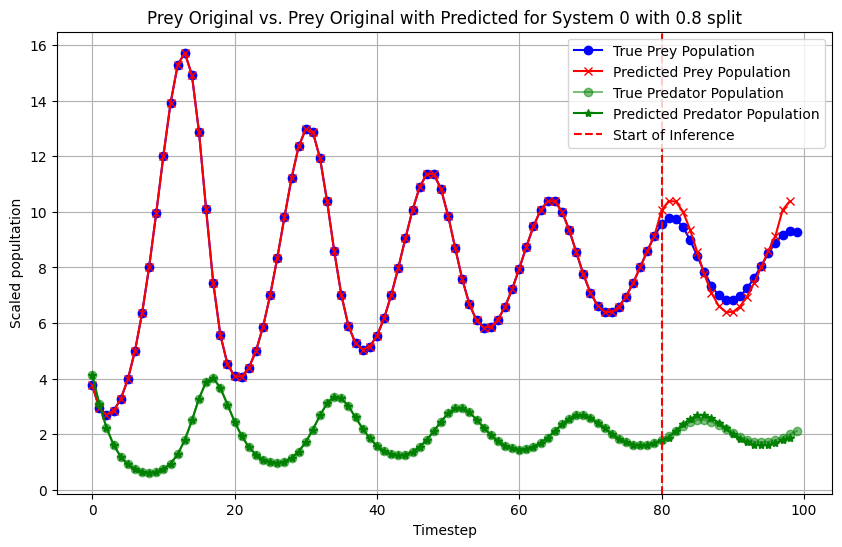

In [12]:
prey_original, predator_original, prey_generated, predator_generated = run_untrained_Model(model, tokeniser, train_set, sequence_no = 0, inference_split = 0.8, plot = True)

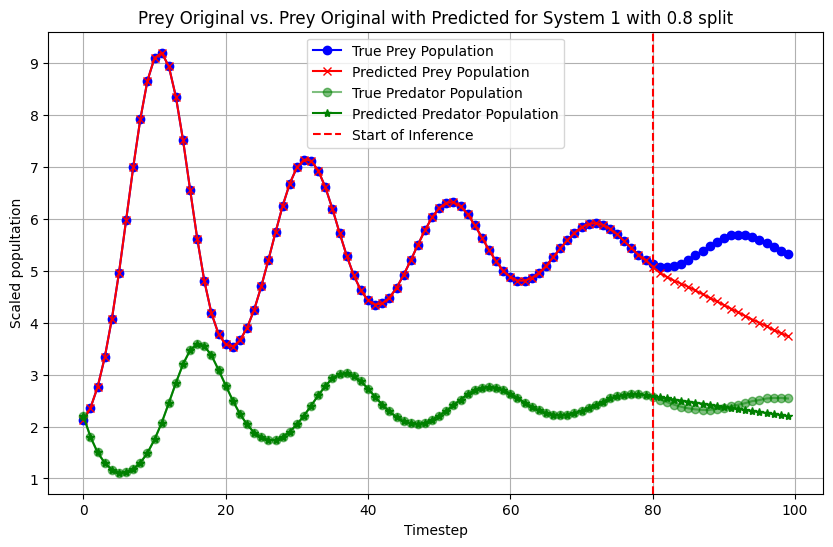

In [ ]:
prey_original, predator_original, prey_generated, predator_generated = run_untrained_Model(model, tokeniser, train_set, sequence_no = 1, inference_split = 0.8, plot = True)

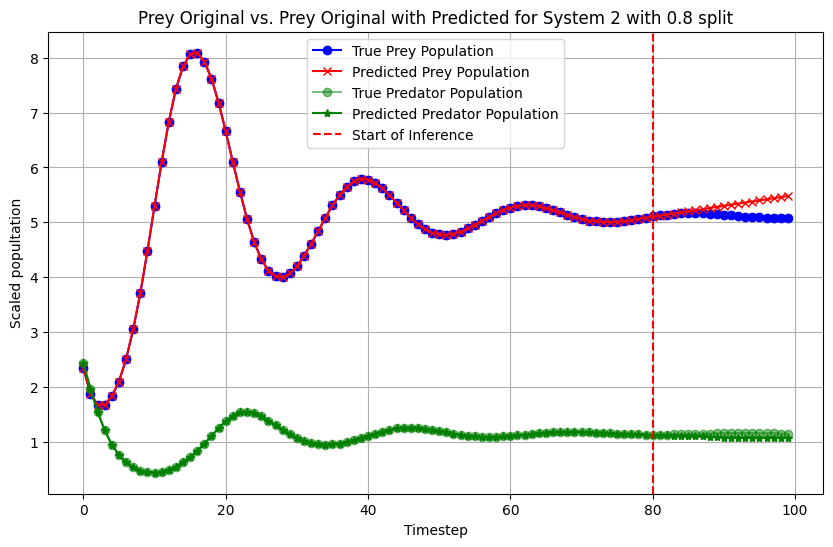

In [ ]:
prey_original, predator_original, prey_generated, predator_generated = run_untrained_Model(model, tokeniser, train_set, sequence_no = 2, inference_split = 0.8, plot = True)